# Gesture Recognition

### Problem Statement

Recognize following gestures captured on webcam attached to Smart-TV and process to relevant operation based getures.

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

In this group project, We are using folowing 2 architectures to build the model and that will be able to predict the 5 gestures correctly.
1. Convolution - RNN architecture
2. CNN with 3D convolution

In [1]:
import numpy as np
import os
import cv2
import datetime
import os
import pandas as pd
# for reading images
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import array_to_img
import keras
from keras.models import Sequential, Model
from keras import initializers
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation, Conv2D, Conv3D, MaxPooling3D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import Adam, SGD
from keras.applications import ResNet50, InceptionV3, VGG16, VGG19, MobileNetV2
from keras.applications.resnet50 import preprocess_input
from keras.regularizers import l2
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from keras import backend as K
tf.set_random_seed(30)
#tf.compat.v1.disable_eager_execution()
%matplotlib inline

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

#### Operaton to clean tesorflow cache.

We can call this function at any time to reset our GPU memory, without restarting your kernel.

In [2]:
def limit_mem():
    K.get_session().close()
    cfg = tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(tf.Session(config=cfg))

Read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 4
total_images_per_video = 30

# While picking images from squence instead of picking all 30 images,
# we pick few image from sequance from which we can identify the gesture
max_images_per_sequence = set(range(0, total_images_per_video, 2))
#max_images_per_sequence.add(total_images_per_video - 1)
print(max_images_per_sequence)
# Image size
# specify image size and channels
img_channels = 3
img_rows = 128
img_cols = 128

{0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28}


Explore data in loaded from disk

In [4]:
print("Train Sequances size: {}".format(len(train_doc)))
print("Test Sequances Size: {}".format(len(val_doc)))

Train Sequances size: 663
Test Sequances Size: 100


### Render Random Sequence Images Data

In [5]:
# Helper function to generate a random affine transform on the iamge
def get_random_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    data = np.float32([[1, 0, dx], [0, 1, dy]])
    return data

In [6]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    width_size = 10
    if(len(images)%3 == 0):
        width_size = len(images)//3
    else:
        width_size = (len(images)//3) + 1
        
    plt.figure(figsize = (16, 8))
    for index, image in enumerate(images):
        ax = plt.subplot(3, width_size, index + 1)
        plt.imshow(image)
plt.show()

rand index:  552
sample_seq_path:  Project_data/train/WIN_20180925_17_49_45_Pro_Right_Swipe_new


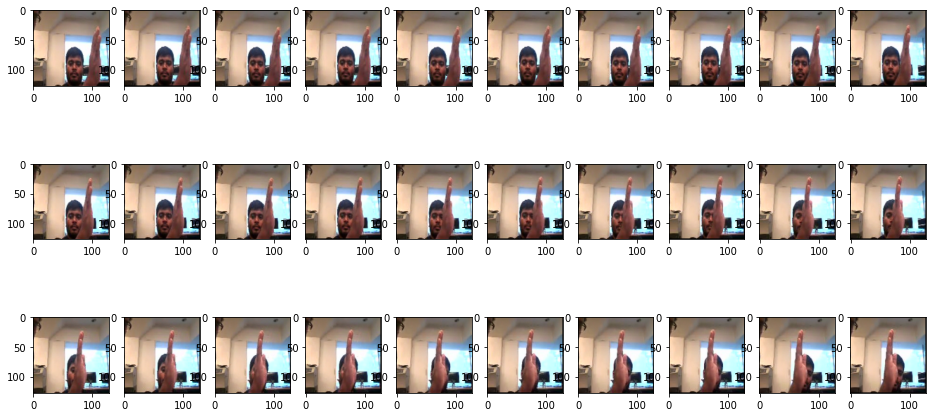

In [7]:
rand_index = random.randint(0, len(train_doc))
print("rand index: ", rand_index)
sample_seq_path = 'Project_data/train' +'/'+ train_doc[rand_index].split(';')[0];
class_name = ('Project_data/train' +'/'+ train_doc[rand_index]).split(';')[2]
print("sample_seq_path: ", sample_seq_path)
images_list = os.listdir(sample_seq_path)
data = get_random_affine()
images = []
for idx, item in enumerate(max_images_per_sequence):
    image = cv2.imread(os.path.join(sample_seq_path, images_list[item]), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image, (img_rows,img_cols), interpolation = cv2.INTER_AREA)
    bileteral_img = cv2.bilateralFilter(resized, 5, 75, 75)

    norm_image = cv2.normalize(resized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    affine_image = cv2.warpAffine(resized, data, (norm_image.shape[0], norm_image.shape[1]))
    images.append(norm_image)
    images.append(affine_image)
    
plot_image(images)

## Custom Sequnce Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
class CustomDataGenerator:
    """
    Generate Data for Keras in batches
    """
    def __init__(self, source_path, folder_list, dataset_portion, batch_size, frames_length=30, skip_frames_length=2):
        """
        Initializes generator basic params
        """
        self.batch_size = batch_size
        self.folder_list = folder_list
        self.source_path = source_path
        self.dataset_portion = dataset_portion
        self.frames_length = frames_length
        self.skip_frames_length = skip_frames_length
        self.img_idx =  list(range(0, self.frames_length, self.skip_frames_length))
        #capture selected list based on requested data portion size
        self.filtered_list = self.pick_random_items()
        
     
    def max_images_per_sequence(self):
        return len(self.img_idx)
    
    def steps_per_epoch(self):
        """
        Calculate number of steps per epoch based on filtered dataset and batch size
        """
        sequences_length = len(self.filtered_list)
        steps_per_epoch = 0
        if (sequences_length%batch_size) == 0:
            steps_per_epoch = int(sequences_length/self.batch_size)
        else:
            steps_per_epoch = (sequences_length//self.batch_size) + 1
        return steps_per_epoch
    
    def normalize(self, image):
        """
         Linear Normalization
        """
        for i in range(3):
            minval = image[:, :, i].min()
            maxval = image[:, :, i].max()
            if minval != maxval:
                image[..., i] = (image[..., i] - minval)/(maxval - minval)
                
    def pick_random_items(self):
        """
         Pick random items from entire data-set.
        """
        if(self.dataset_portion == 1):
            return self.folder_list

        # Step-1 Create disctionary for all class elements
        data_dict = {}
        for item in self.folder_list:
            class_val = int(item.split(';')[2])
            if class_val not in data_dict.keys():
                data_dict[class_val] = []
            data_dict[class_val].append(item)

        # create list to pick items from each class based on data set size proportinal to available class wise data.
        selected_list = []
        for class_val, class_list in data_dict.items():
            random_list = np.random.permutation(class_list)
            selected_list.extend(random_list[: int(len(random_list) * self.dataset_portion)])

        return np.random.permutation(selected_list)
    
    def generator(self):
        """
        Python Generator to return batch data
        """
        print( 'Source path = ', self.source_path, '; batch size =', self.batch_size, '; Picked Data size: ', len(self.filtered_list),
              '; total data set size: ', len(self.folder_list))
        while True:
            shuffled_list = np.random.permutation(self.filtered_list)
            num_batches = len(shuffled_list)//self.batch_size
            #print("num_batches: ", num_batches)
            batch_count = 0
            # we iterate over the number of batches
            for batch in range(num_batches):
                # img_idx is the number of images you use for each video, (image_height, image_width) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((self.batch_size, len(self.img_idx), img_rows, img_cols, 3))
                # batch_labels is the one hot representation of the output
                batch_labels = np.zeros((self.batch_size, 5))
                for folder in range(self.batch_size): # iterate over the batch_size
                    images_base_path = os.path.join(self.source_path, shuffled_list[folder + (batch*self.batch_size)].split(';')[0])
                    imgs = os.listdir(images_base_path) # read all the images in the folder
                    for idx,item in enumerate(self.img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = cv2.imread(os.path.join(images_base_path, imgs[item]), cv2.IMREAD_COLOR)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        resized = cv2.resize(image, (img_rows,img_cols), interpolation = cv2.INTER_AREA)
                        bileteral_img = cv2.bilateralFilter(resized, 5, 75, 75)
                        norm_image = cv2.normalize(bileteral_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                        
                        batch_data[folder,idx,:,:,0] = norm_image[:, :, 0]
                        batch_data[folder,idx,:,:,1] = norm_image[:, :, 1]
                        batch_data[folder,idx,:,:,2] = norm_image[:, :, 2]

                    batch_labels[folder, int(shuffled_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                #you yield the batch_data and the batch_labels, remember what does yield do
                yield batch_data, batch_labels


            # write the code for the remaining data points which are left after full batches
            remaining_folders = len(shuffled_list) - num_batches * self.batch_size
            if(remaining_folders > 0):
                #print("remaining_folders: ", remaining_folders, " batch_count: ", batch_count)
                # img_idx is the number of images you use for each video, (image_height, image_width) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((remaining_folders, len(self.img_idx), img_rows, img_cols, 3))
                # batch_labels is the one hot representation of the output
                batch_labels = np.zeros((remaining_folders, 5))
                for folder in range(remaining_folders):
                    images_base_path = os.path.join(self.source_path, shuffled_list[folder + (num_batches*self.batch_size)].split(';')[0])
                    imgs = os.listdir(images_base_path) # read all the images in the folder
                    for idx,item in enumerate(self.img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = cv2.imread(os.path.join(images_base_path, imgs[item]), cv2.IMREAD_COLOR)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        resized = cv2.resize(image, (img_rows,img_cols), interpolation = cv2.INTER_AREA)
                        bileteral_img = cv2.bilateralFilter(resized, 5, 75, 75)
                        norm_image = cv2.normalize(bileteral_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

                        batch_data[folder,idx,:,:,0] = norm_image[:, :, 0]
                        batch_data[folder,idx,:,:,1] = norm_image[:, :, 1]
                        batch_data[folder,idx,:,:,2] = norm_image[:, :, 2]
                    # reduce remaining folders    
                    remaining_folders -= 1    
                    batch_labels[folder, int(shuffled_list[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
                #you yield the batch_data and the batch_labels, remember what does yield do    
                yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model Building 

As part of this model building we use 2 architectures to build 2 different models.

1. CNN + RNN architecture
2. 3D convolutional network

#### Initialize Basic Hyperparameters

In [9]:
filter_length = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
gesture_classes = 5
hidden_dims = 128
train_data_size = 0.4
test_data_size = 0.5

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_epochs = 20
print ('# epochs =', num_epochs)

# epochs = 20


Source path =  Project_data/train ; batch size = 5 ; Picked Data size:  263 ; total data set size:  663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


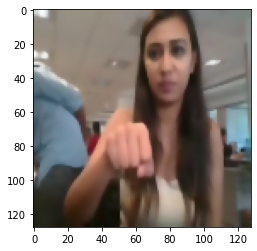

In [11]:
# create and Test Generator
batch_size = 5
train_generator = CustomDataGenerator(train_path, train_doc, train_data_size, batch_size)
batdata,batlabel = next(train_generator.generator())
plt.imshow(batdata[1,2])

## Model -1 (CNN + RNN architecture)

The conv2D network will extract a feature vector for each image, and a sequence of these feature vectors is then fed to an RNN-based network. The output of the RNN is a regular softmax. 

As part of this model we use Resnet-18 as Convolution Network to extract features then we feed convolution output to RNN network.

### Option1 - ResNet50 + LSTM 

#### Initialize Data Generator

In [112]:
limit_mem()
batch_size = 10
num_epochs = 10
train_generator = CustomDataGenerator(train_path, train_doc, 1, batch_size)
val_generator = CustomDataGenerator(val_path, val_doc, 1, batch_size)

In [113]:
def build_model():
    # create the base pre-trained model
    model = Sequential()
    
    base_model = ResNet50(weights='imagenet', input_shape = (img_rows, img_cols, 3),
                          include_top=False)

    for layer in base_model.layers[:]:
        layer.trainable=False
    
    for layer in base_model.layers[-3:]:
        layer.trainable=True
    # add a global spatial average pooling layer
    model.add(TimeDistributed(base_model, input_shape=(train_generator.max_images_per_sequence(), img_rows, img_cols, 3)))
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    
    model.add(LSTM(rnn_output_size, 
                   activation='selu',
                   kernel_initializer='lecun_normal',
                   return_sequences=False,
                   dropout=dropout, kernel_regularizer=l2(0.01)))
    
    # Layer 3 - Dense FFN with Dropout
    # 1st Dense layer with 512 neurons 
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation = 'selu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(keras.layers.Dropout(dropout))

    # 2nd Dense layer with 128 neurons
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation = 'selu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(keras.layers.Dropout(0.25))
    
    # output layer
    model.add(Dense(gesture_classes,
                    activation = 'softmax',
                    kernel_initializer = weights,
                    name='output'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['categorical_accuracy'])
    
    return model

In [114]:
# Create model instance and check model summary
model = build_model()
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_29 (TimeDis (None, 15, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_30 (TimeDis (None, 15, 2048)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               1114624   
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_75 (Batc (None, 128)               512       
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)              

### Fit - Model

Fit ResNet50 + LSTM model on input data.

#### I - Create Model checkpoint callback to persist best model parameter

In [115]:
model_name = 'model_ResNet_LSTM' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [116]:
# Run model fit-generator
history = model.fit_generator(
                    train_generator.generator(),
                    epochs=num_epochs,
                    validation_data=val_generator.generator(),
                    verbose=True,
                    shuffle=True,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    validation_steps=val_generator.steps_per_epoch(),
                    callbacks=callbacks_list,
                    workers=1,
                    initial_epoch=0)

Source path =  Project_data/val ; batch size = 10 ; Picked Data size:  100 ; total data set size:  100
Source path =  Project_data/train ; batch size = 10 ; Picked Data size:  663 ; total data set size:  663
Epoch 1/10
67/67 [==============================] - 41s 609ms/step - loss: 7.5542 - categorical_accuracy: 0.2594 - val_loss: 6.7762 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 6.77619, saving model to model_ResNet_LSTM_2021-01-3018_02_58.873129/model-00001-7.56809-0.25943-6.77619-0.21000.h5
Epoch 2/10
67/67 [==============================] - 29s 433ms/step - loss: 5.8546 - categorical_accuracy: 0.2805 - val_loss: 5.0720 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss improved from 6.77619 to 5.07196, saving model to model_ResNet_LSTM_2021-01-3018_02_58.873129/model-00002-5.85336-0.28054-5.07196-0.21000.h5
Epoch 3/10
67/67 [==============================] - 32s 477ms/step - loss: 4.6547 - categorical_accuracy: 0.3997 - val_loss: 5.3160 - 

### Visualize Details

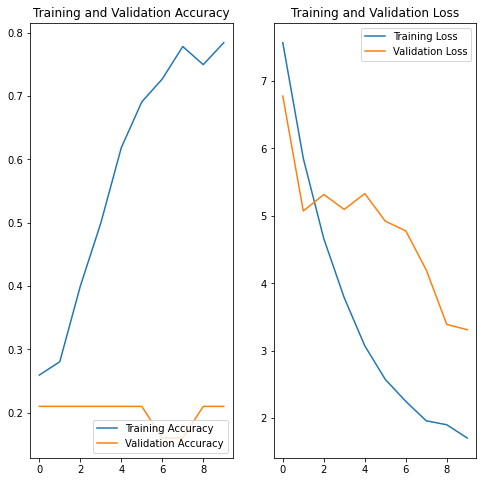

In [117]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### ResNet50 + RNN model is overfitting on training performing very poorly on test data. On train it can provide accuracy 80% but test accuracy stood at 22% only.

### Option 2 VGG19 + GRU

#### Initiliaze Data Generator

In [18]:
limit_mem()
batch_size = 10
num_epochs = 20
train_generator = CustomDataGenerator(train_path, train_doc, 1, batch_size)
val_generator = CustomDataGenerator(val_path, val_doc, 1, batch_size)

#### Define Model & create Model Instance

In [19]:
def build_model2():
    # create the base pre-trained model
    model = Sequential()
    
    base_model = VGG19(weights='imagenet',
                          input_shape = (img_rows, img_cols, 3),
                          include_top=False)

    for layer in base_model.layers[:]:
        layer.trainable=False
    
    for layer in base_model.layers[-3:]:
        layer.trainable=True
        
    # add a global spatial average pooling layer
    model.add(TimeDistributed(base_model, input_shape=(train_generator.max_images_per_sequence(), img_rows, img_cols, 3)))
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    
    model.add(GRU(rnn_output_size, 
                   activation='selu',
                   kernel_initializer='lecun_normal',
                   return_sequences=False,
                   kernel_regularizer=l2(0.01),
                   dropout=dropout))
    
    # Layer 3 - Dense FFN with Dropout
    # 1st Dense layer with 512 neurons 
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(keras.layers.Dropout(dropout))

    # 2nd Dense layer with 128 neurons
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(keras.layers.Dropout(dropout))
    
    # output layer
    model.add(Dense(gesture_classes,
                    activation = 'softmax',
                    kernel_initializer = weights,
                    name='output'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['categorical_accuracy'])
    
    return model

In [20]:
# Create model instance and check model summary
model2 = build_model2()
model2.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 4, 4, 512)     20024384  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 512)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               246144    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________

In [21]:
model_name1 = 'model_VGG19_GRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name1):
    os.mkdir(model_name1)
        
filepath = model_name1 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3,min_lr=0.0000001)

checkpoint1 = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
callbacks_list = [LR, checkpoint1, ES]

In [22]:
# Run model fit-generator
history2 = model2.fit_generator(
                    train_generator.generator(),
                    epochs=num_epochs,
                    validation_data=val_generator.generator(),
                    verbose=True,
                    shuffle=True,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    validation_steps=val_generator.steps_per_epoch(),
                    callbacks=callbacks_list,
                    workers=1,
                    initial_epoch=0)

Source path =  Project_data/train ; batch size = 10 ; Picked Data size:  Source path =  Project_data/val ; batch size = 663 ; total data set size:  663
10 ; Picked Data size:  100 ; total data set size:  100
Epoch 1/20
67/67 [==============================] - 56s 835ms/step - loss: 6.0886 - categorical_accuracy: 0.1931 - val_loss: 4.6529 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss improved from inf to 4.65294, saving model to model_VGG19_GRU_2021-01-3117_07_16.849380/model-00001-6.10362-0.19306-4.65294-0.22000.h5
Epoch 2/20
67/67 [==============================] - 44s 658ms/step - loss: 4.5886 - categorical_accuracy: 0.2066 - val_loss: 4.1367 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss improved from 4.65294 to 4.13667, saving model to model_VGG19_GRU_2021-01-3117_07_16.849380/model-00002-4.59531-0.20664-4.13667-0.23000.h5
Epoch 3/20
67/67 [==============================] - 44s 661ms/step - loss: 3.9669 - categorical_accuracy: 0.2428 - val_loss: 3.5786 - val_

### Visualize the data

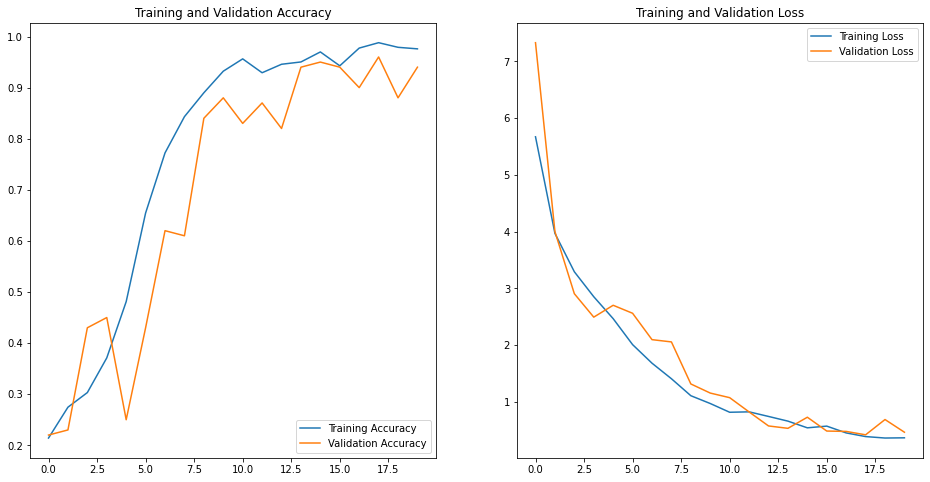

In [21]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(val_acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### CNN + RNN (VGG_19 + GRU) provides better accuracy on both train  98.79% & test accuracy 96%. On VGG-19 we train weights of top 3 layers and weights for remaining layers were frozen.

### Option-3 Model Standard CNN with 3D Convolution
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model.

#### Initialize Data Generators

In [22]:
limit_mem()
batch_size = 10
train_generator = CustomDataGenerator(train_path, train_doc, 1, batch_size)
val_generator = CustomDataGenerator(val_path, val_doc, 1, batch_size)

#### Define & Create Model Instance

In [23]:
def build_model3(): 
        kernel=(3,3,3)
        dropout=0.4
        pool=(2,2,2)
        activ='relu'
        model =Sequential()
    
        model.add(Conv3D(16, kernel_size=kernel, padding = 'same', 
                     input_shape = (train_generator.max_images_per_sequence(), img_rows, img_cols, 3)))
        model.add(Activation(activ))
        model.add(Conv3D(16, kernel, padding='same'))
        model.add(Activation(activ))
        model.add(Conv3D(16, kernel, padding='same'))
        model.add(Activation(activ))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=pool))

        model.add(Conv3D(32, kernel, padding='same'))
        model.add(Activation(activ))
        model.add(Conv3D(32, kernel, padding='same'))
        model.add(Activation(activ))
        model.add(Conv3D(32, kernel, padding='same'))
        model.add(Activation(activ))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=pool))

        model.add(Conv3D(64, kernel, padding='same'))
        model.add(Activation(activ))
        model.add(Conv3D(64, kernel, padding='same'))
        model.add(Activation(activ))
        model.add(Conv3D(64, kernel, padding='same'))
        model.add(Activation(activ))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=pool))
        
        model.add(Flatten())
        model.add(Dense(1000,activation=activ))
        
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(100,activation=activ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(gesture_classes,activation='softmax'))

        #optimiser = Adam(lr=learning_rate)
        optimiser = SGD(lr=learning_rate, nesterov=True)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
# Create model instance and check model summary
model3 = build_model3()
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 128, 128, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 128, 128, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 128, 128, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 128, 128, 16)  0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 15, 128, 128, 16)  6928      
_________________________________________________________________
activation_3 (Activation)    (None, 15, 128, 128, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 128, 128, 16) 

In [25]:
model_name2 = 'model_CNN_3DConv' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name2):
    os.mkdir(model_name2)
        
filepath = model_name2 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint2 = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3,min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks_list = [LR, checkpoint2]

In [26]:
# Run model fit-generator
history3 = model3.fit_generator(
                    train_generator.generator(),
                    epochs=num_epochs,
                    validation_data=val_generator.generator(),
                    verbose=True,
                    shuffle=True,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    validation_steps=val_generator.steps_per_epoch(),
                    callbacks=callbacks_list,
                    workers=1,
                    initial_epoch=0)

Source path =  Project_data/val ; batch size = 10 ; Picked Data size:  100 ; total data set size:  100
Source path =  Project_data/train ; batch size = 10 ; Picked Data size:  663 ; total data set size:  663
Epoch 1/20
67/67 [==============================] - 50s 747ms/step - loss: 2.2029 - categorical_accuracy: 0.2956 - val_loss: 2.0373 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 2.03734, saving model to model_CNN_3DConv_2021-01-3018_02_58.873129/model-00001-2.19390-0.29563-2.03734-0.23000.h5
Epoch 2/20
67/67 [==============================] - 44s 659ms/step - loss: 1.7545 - categorical_accuracy: 0.4148 - val_loss: 1.5528 - val_categorical_accuracy: 0.3400

Epoch 00002: val_loss improved from 2.03734 to 1.55277, saving model to model_CNN_3DConv_2021-01-3018_02_58.873129/model-00002-1.74510-0.41478-1.55277-0.34000.h5
Epoch 3/20
67/67 [==============================] - 44s 655ms/step - loss: 1.6416 - categorical_accuracy: 0.4540 - val_loss: 1.5198 - va

### Visualize the Model Data

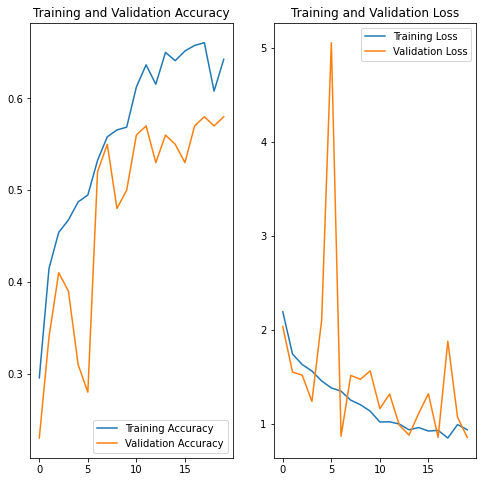

In [27]:
acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 3D CNN with kernel size 3 was underfit the model with 65% train accuracy anf 58% test accuracy.

### Option-4 Model Standard CNN with 3D Convolution
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model.
- As part this we use kernel size 3 and 2

#### Initialize Data Generator

In [12]:
limit_mem()
batch_size = 10
num_epochs = 30
train_generator = CustomDataGenerator(train_path, train_doc, 1, batch_size)
val_generator = CustomDataGenerator(val_path, val_doc, 1, batch_size)

#### Define & Create Model Instance

In [13]:
def build_model4():
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
        input_shape = (train_generator.max_images_per_sequence(), img_rows, img_cols, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv3D(16, (3, 3, 1), padding='same',
                 input_shape = (train_generator.max_images_per_sequence(), img_rows, img_cols, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 1), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 1), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv3D(128, (3, 3, 1), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(gesture_classes,activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
# Create model instance and check model summary
model4 = build_model4()
model4.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 128, 128, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 15, 128, 128, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 128, 128, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 128, 128, 16)  2320      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 128, 128, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 128, 128, 16)  64        
_______________________________________

In [15]:
model_name4 = 'model_CNN_3DConv2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name4):
    os.mkdir(model_name4)
        
filepath = model_name4 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint2 = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3,min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks_list = [LR, checkpoint2]

In [16]:
# Run model fit-generator
history4 = model4.fit_generator(
                    train_generator.generator(),
                    epochs=num_epochs,
                    validation_data=val_generator.generator(),
                    verbose=True,
                    shuffle=True,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    validation_steps=val_generator.steps_per_epoch(),
                    callbacks=callbacks_list,
                    workers=1,
                    initial_epoch=0)


Source path =  Project_data/val ; batch size = 10 ; Picked Data size:  100 ; total data set size:  Source path = 100
 Project_data/train ; batch size = 10 ; Picked Data size:  663 ; total data set size:  663
Epoch 1/30
67/67 [==============================] - 99s 1s/step - loss: 1.5555 - categorical_accuracy: 0.4404 - val_loss: 3.3715 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 3.37148, saving model to model_CNN_3DConv2_2021-01-3117_07_16.849380/model-00001-1.55492-0.44042-3.37148-0.16000.h5
Epoch 2/30
67/67 [==============================] - 25s 371ms/step - loss: 0.9881 - categorical_accuracy: 0.6290 - val_loss: 3.0081 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss improved from 3.37148 to 3.00814, saving model to model_CNN_3DConv2_2021-01-3117_07_16.849380/model-00002-0.98803-0.62896-3.00814-0.16000.h5
Epoch 3/30
67/67 [==============================] - 27s 396ms/step - loss: 0.7134 - categorical_accuracy: 0.7300 - val_loss: 3.9977 - va

67/67 [==============================] - 27s 405ms/step - loss: 0.1463 - categorical_accuracy: 0.9668 - val_loss: 0.4732 - val_categorical_accuracy: 0.9500

Epoch 00029: val_loss did not improve from 0.01817
Epoch 30/30
67/67 [==============================] - 27s 404ms/step - loss: 0.1498 - categorical_accuracy: 0.9623 - val_loss: 0.5767 - val_categorical_accuracy: 0.9600

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00030: val_loss did not improve from 0.01817


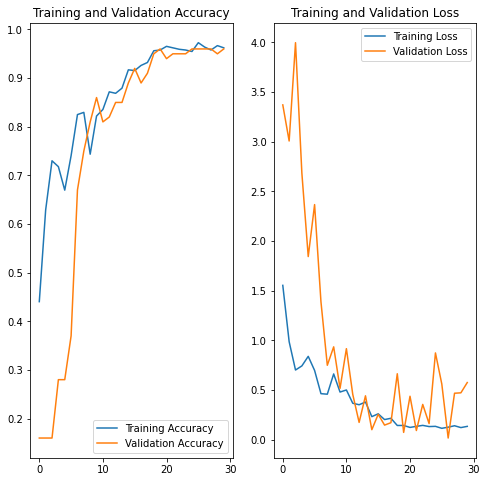

In [17]:
acc = history4.history['categorical_accuracy']
val_acc = history4.history['val_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 3D CNN with kernel size 3x3x1 provides better train accuracy 97% and test accuracy 96%

### Using MobileNet transfer learning

In [130]:
limit_mem()
batch_size = 5
num_epochs = 30
train_generator = CustomDataGenerator(train_path, train_doc, 1, batch_size)
val_generator = CustomDataGenerator(val_path, val_doc, 1, batch_size)

In [135]:
from keras.applications import mobilenet

mobilenet_wt = mobilenet.MobileNet(input_shape=(img_rows, img_cols, 3), weights='imagenet', include_top=False)


def model_mobilenet():
        model = Sequential()
        model.add(TimeDistributed(mobilenet_wt,input_shape=(train_generator.max_images_per_sequence(), img_rows, img_cols, 3)))
 
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(64))
        model.add(Dropout(dropout))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(gesture_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [136]:
# Create model instance and check model saummary
model_mob = model_mobilenet()
model_mob.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_39 (TimeDis (None, 15, 4, 4, 1024)    3228864   
_________________________________________________________________
time_distributed_40 (TimeDis (None, 15, 4, 4, 1024)    4096      
_________________________________________________________________
time_distributed_41 (TimeDis (None, 15, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 15, 4096)          0         
_________________________________________________________________
gru_8 (GRU)                  (None, 64)                798912    
_________________________________________________________________
dropout_51 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)              

In [137]:
model_name1 = 'model_mobilenet_train_GRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name1):
    os.mkdir(model_name1)
        
filepath = model_name1 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3,min_lr=0.0000001)

checkpoint1 = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
callbacks_list = [LR, checkpoint1]

In [138]:
history_mob = model_mob.fit_generator(
                    train_generator.generator(),
                    epochs=num_epochs,
                    validation_data=val_generator.generator(),
                    verbose=True,
                    shuffle=True,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    validation_steps=val_generator.steps_per_epoch(),
                    callbacks=callbacks_list,
                    workers=1,
                    initial_epoch=0)

Source path =  Project_data/val ; batch size = 5 ; Picked Data size:  100 ; total data set size:  100
Source path =  Project_data/train ; batch size = 5 ; Picked Data size:  663 ; total data set size:  663
Epoch 1/30
133/133 [==============================] - 61s 459ms/step - loss: 1.3554 - categorical_accuracy: 0.4570 - val_loss: 0.9215 - val_categorical_accuracy: 0.7000

Epoch 00001: val_loss improved from inf to 0.92151, saving model to model_mobilenet_train_GRU_2021-01-3018_02_58.873129/model-00001-1.35718-0.45701-0.92151-0.70000.h5
Epoch 2/30
133/133 [==============================] - 41s 308ms/step - loss: 0.9245 - categorical_accuracy: 0.6546 - val_loss: 1.4302 - val_categorical_accuracy: 0.6700

Epoch 00002: val_loss did not improve from 0.92151
Epoch 3/30
133/133 [==============================] - 42s 318ms/step - loss: 0.7080 - categorical_accuracy: 0.7813 - val_loss: 0.3575 - val_categorical_accuracy: 0.7300

Epoch 00003: val_loss improved from 0.92151 to 0.35753, saving mod

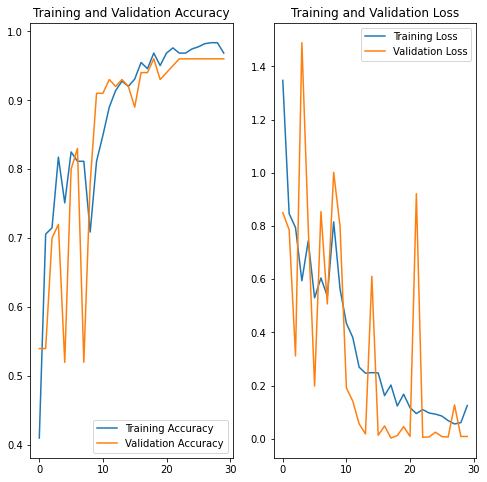

In [85]:
acc = history_mob.history['categorical_accuracy']
val_acc = history_mob.history['val_categorical_accuracy']

loss = history_mob.history['loss']
val_loss = history_mob.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### CNN + RNN (MobileNet + GRU) provides better accuracy on both train  97.79% & test accuracy 96%. We use MobileNet architecture only and retrain entire parameters

In [54]:
limit_mem()

## NASNet Transfer Learning

In [55]:
from keras.applications import NASNetMobile

nasnet_wt = NASNetMobile(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

def model_nasnet():
        model = Sequential()
        model.add(TimeDistributed(nasnet_wt,input_shape=(len(max_images_per_sequence), img_rows, img_cols, 3)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(64))
        model.add(Dropout(dropout))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(gesture_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [56]:
batch_size = 10
train_generator = CustomDataGenerator(train_path, train_doc, 1, batch_size)
val_generator = CustomDataGenerator(val_path, val_doc, 1, batch_size)

# Create model instance and check model saummary
model_nas = model_nasnet()
model_nas.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 15, 4, 4, 1056)    4269716   
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 4, 4, 1056)    4224      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 2, 2, 1056)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 4224)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                823488    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
__________

In [57]:
for layer in model_nas.layers[:]:
    layer.trainable=False
    
for layer in model_nas.layers[-5:]:
    layer.trainable=True

In [58]:
model_nas.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model_nas.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 15, 4, 4, 1056)    4269716   
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 4, 4, 1056)    4224      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 2, 2, 1056)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 4224)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                823488    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
__________

In [59]:
model_name = 'model_NASNet_GRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)
callbacks_list = [checkpoint, ES, LR]

In [61]:
# Run model fit-generator
history_nas = model_nas.fit_generator(
                    train_generator.generator(),
                    epochs=20,
                    validation_data=val_generator.generator(),
                    verbose=True,
                    shuffle=True,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    validation_steps=val_generator.steps_per_epoch(),
                    callbacks=callbacks_list,
                    workers=1,
                    initial_epoch=0)

Source path =  Project_data/val ; batch size = 10 ; Picked Data size:  100 ; total data set size:  100
Source path =  Project_data/train ; batch size = 10 ; Picked Data size:  663 ; total data set size:  663
Epoch 1/20
67/67 [==============================] - 62s 925ms/step - loss: 1.7086 - categorical_accuracy: 0.2442 - val_loss: 1.6535 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_NASNet_GRU_2021-01-3006_24_53.742643/model-00001-1.71488-0.23982-1.65346-0.20000.h5
Epoch 2/20
67/67 [==============================] - 34s 500ms/step - loss: 1.5435 - categorical_accuracy: 0.3229 - val_loss: 1.6506 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_NASNet_GRU_2021-01-3006_24_53.742643/model-00002-1.54497-0.32278-1.65059-0.26000.h5
Epoch 3/20
67/67 [==============================] - 36s 542ms/step - loss: 1.4386 - categorical_accuracy: 0.3721 - val_loss: 1.4493 - val_categorical_accuracy: 0.4200

Epoch 00003: saving model to model_NASNet_GRU_2021

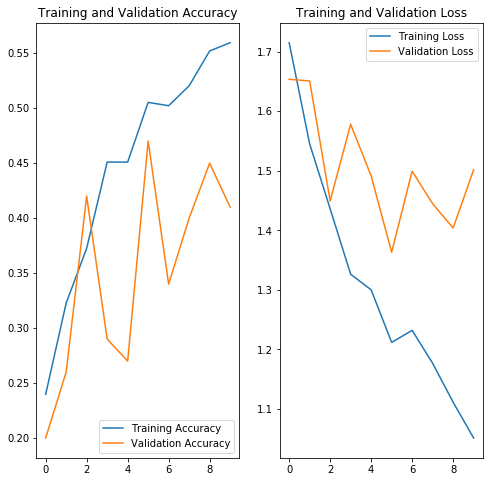

In [62]:
acc = history_nas.history['categorical_accuracy']
val_acc = history_nas.history['val_categorical_accuracy']

loss = history_nas.history['loss']
val_loss = history_nas.history['val_loss']

epochs_range = range(len(val_loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Userdefined CNN + RNN (GRU)

In [40]:

def model_cnnrnn_ud():
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(len(max_images_per_sequence), img_rows, img_cols, 3)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(64))
        model.add(Dropout(dropout))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(gesture_classes, activation='softmax'))
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [41]:
batch_size = 10
train_generator = CustomDataGenerator(train_path, train_doc, 1, batch_size)
val_generator = CustomDataGenerator(val_path, val_doc, 1, batch_size)

# Create model instance and check model summary
model_cnnrnn_ud1 = model_cnnrnn_ud()
model_cnnrnn_ud1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_57 (TimeDis (None, 15, 128, 128, 16)  448       
_________________________________________________________________
time_distributed_58 (TimeDis (None, 15, 128, 128, 16)  64        
_________________________________________________________________
time_distributed_59 (TimeDis (None, 15, 64, 64, 16)    0         
_________________________________________________________________
time_distributed_60 (TimeDis (None, 15, 64, 64, 32)    4640      
_________________________________________________________________
time_distributed_61 (TimeDis (None, 15, 64, 64, 32)    128       
_________________________________________________________________
time_distributed_62 (TimeDis (None, 15, 32, 32, 32)    0         
_________________________________________________________________
time_distributed_63 (TimeDis (None, 15, 32, 32, 64)    18496     
__________

In [42]:
model_name = 'model_CNNRNN_UD1_GRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)
callbacks_list = [checkpoint, ES, LR]

In [43]:
# Run model fit-generator
history_cnnrnn_ud1 = model_cnnrnn_ud1.fit_generator(
                    train_generator.generator(),
                    epochs=30,
                    validation_data=val_generator.generator(),
                    verbose=True,
                    shuffle=True,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    validation_steps=val_generator.steps_per_epoch(),
                    callbacks=callbacks_list,
                    workers=1,
                    initial_epoch=0)

Source path =  Project_data/valSource path =  Project_data/train ; batch size = 10 Epoch 1/30
; Picked Data size:  ; batch size = 10 ; Picked Data size:  100 ; total data set size:  100
 663 ; total data set size:  663
67/67 [==============================] - 38s 571ms/step - loss: 1.6884 - categorical_accuracy: 0.2259 - val_loss: 1.5242 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_CNNRNN_UD1_GRU_2021-01-3008_07_21.226274/model-00001-1.69058-0.22474-1.52420-0.33000.h5
Epoch 2/30
67/67 [==============================] - 34s 505ms/step - loss: 1.5467 - categorical_accuracy: 0.2986 - val_loss: 1.4242 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_CNNRNN_UD1_GRU_2021-01-3008_07_21.226274/model-00002-1.54687-0.30166-1.42423-0.53000.h5
Epoch 3/30
67/67 [==============================] - 35s 525ms/step - loss: 1.4834 - categorical_accuracy: 0.3751 - val_loss: 1.3971 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to model_CNNRNN_

67/67 [==============================] - 34s 506ms/step - loss: 0.9610 - categorical_accuracy: 0.6125 - val_loss: 0.9838 - val_categorical_accuracy: 0.6300

Epoch 00028: saving model to model_CNNRNN_UD1_GRU_2021-01-3008_07_21.226274/model-00028-0.95850-0.61538-0.98380-0.63000.h5
Epoch 29/30
67/67 [==============================] - 33s 499ms/step - loss: 0.9499 - categorical_accuracy: 0.6323 - val_loss: 0.9775 - val_categorical_accuracy: 0.6300

Epoch 00029: saving model to model_CNNRNN_UD1_GRU_2021-01-3008_07_21.226274/model-00029-0.94424-0.63198-0.97754-0.63000.h5
Epoch 30/30
67/67 [==============================] - 34s 508ms/step - loss: 0.9395 - categorical_accuracy: 0.6319 - val_loss: 0.9706 - val_categorical_accuracy: 0.6200

Epoch 00030: saving model to model_CNNRNN_UD1_GRU_2021-01-3008_07_21.226274/model-00030-0.93560-0.63499-0.97057-0.62000.h5


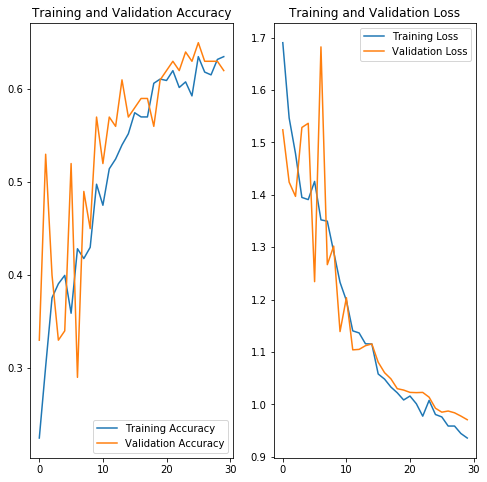

In [44]:
acc = history_cnnrnn_ud1.history['categorical_accuracy']
val_acc = history_cnnrnn_ud1.history['val_categorical_accuracy']

loss = history_cnnrnn_ud1.history['loss']
val_loss = history_cnnrnn_ud1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()